In [58]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cartopy
import cartopy.crs as ccrs
import matplotlib
%matplotlib inline
from netCDF4 import Dataset


import iris
import iris.plot as iplt
import iris.quickplot as qplt
from iris.coords import DimCoord
from iris.cube import Cube
import matplotlib.colors as colors
from sklearn import datasets
import iris.analysis
import numpy.ma as ma

import matplotlib.ticker as mticker
from matplotlib.ticker import MultipleLocator
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point


from iris.experimental.regrid import regrid_weighted_curvilinear_to_rectilinear

import matplotlib.cm as mpl_cm
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


import math
from matplotlib import mlab

import warnings
warnings.filterwarnings("ignore")

## load the 'amoc_mean_ann' variable in the mid-Holocene (derived from the CVDP file) using Iris cube 

11 models: CESM2, EC-Earth3-LR, FGOALS-f3-L, FGOALS-g3, GISS-E2-1-G, HadGEM3-GC31, INM-CM4-8, IPSL-CM6A-LR, 
        MPI-ESM1-2-LR, MRI-ESM2-0, NorESM2-LM

However, no CESM2 and Fgoals-g3 model at this stage. 
Because for CESM2, we can't load the variable directly with iris cube , as missing data dimensions for multi-valued DimCoord 'latitude'.
For Fgoals-g3, post-processed AMOC data from CVDP is unavailable now, so we will load the data which is downloaded from the Earth System Grid Federation (ESGF; Balaji et al., 2018, available at https://esgf-node.llnl.gov/search/cmip6/) later.

## First, load the 'amoc_mean_ann' data for the 9 models

In [59]:
cube_ec_amoc = iris.load_cube('../data_netcdf/midHolocene/EC-Earth3-LR_midHolocene.cvdp_data.2245-2445.nc', 'amoc_mean_ann') #'grid_latitude'

cube_fgoalsf3_amoc = iris.load_cube('../data_netcdf/midHolocene/FGOALS-f3-L_midHolocene.cvdp_data.1020-1219.nc', 'amoc_mean_ann') 

cube_giss_amoc = iris.load_cube('../data_netcdf/midHolocene/GISS-E2-1-G_midHolocene.cvdp_data.2900-2999.nc', 'amoc_mean_ann')

cube_hadgem_amoc = iris.load_cube('../data_netcdf/midHolocene/HadGEM3-GC31-LL_midHolocene.cvdp_data.2250-2349.nc', 'amoc_mean_ann') #'grid_latitude'

cube_inm_amoc = iris.load_cube('../data_netcdf/midHolocene/INM-CM4-8_midHolocene.cvdp_data.1880-2079.nc', 'amoc_mean_ann')

cube_ipsl_amoc = iris.load_cube('../data_netcdf/midHolocene/IPSL-CM6A-LR_midHolocene.cvdp_data.1850-2399.nc', 'amoc_mean_ann') #'Vertical W levels'

cube_mpi2_amoc = iris.load_cube('../data_netcdf/midHolocene/MPI-ESM1-2-LR_midHolocene.cvdp_data.1001-1500.nc', 'amoc_mean_ann')

cube_mri_amoc = iris.load_cube('../data_netcdf/midHolocene/MRI-ESM2-0_midHolocene.cvdp_data.1951-2150.nc', 'amoc_mean_ann')

cube_noresm2_amoc = iris.load_cube('../data_netcdf/midHolocene/NorESM2-LM_midHolocene.cvdp_data.2101-2200.nc', 'amoc_mean_ann')


## load the  'amoc_mean_ann' data for CESM2 & Fgoals-g3, and then create a new cube to put the data in

#### load mh_cesm2

In [60]:
filename_3='../data_netcdf/midHolocene/CESM2_midHolocene.cvdp_data.1-700.nc'
cesm=xr.open_dataset(filename_3,decode_times=False)

In [61]:
cesm_amoc_data=cesm.amoc_mean_ann.values
cesm_lev_data=cesm.lev.values
cesm_lat_data=cesm.lat_amoc.values

In [62]:
depth = DimCoord(cesm_lev_data, standard_name='depth', units='m')
latitude = DimCoord(cesm_lat_data, standard_name='latitude', units='degrees')

cube_cesm_amoc = Cube(cesm_amoc_data,dim_coords_and_dims=[(depth, 0), (latitude, 1)])

## Regridding

#### most models have dimension coord -- depth & latitude, but some have different coord names
#### e.g. EC-Earth3 and HadGEM3 have coord -- depth & grid_latitude
#### IPSL has coord -- vertical W levels & latitude

In [63]:
amoc_cube=[cube_cesm_amoc, cube_ec_amoc, cube_fgoalsf3_amoc, 
           cube_giss_amoc, cube_hadgem_amoc, cube_inm_amoc, 
           cube_ipsl_amoc, cube_mpi2_amoc, cube_mri_amoc, cube_noresm2_amoc]

In [64]:
pmip4_modelname=['cesm','ec','fgoalsf3','giss','hadgem','inm','ipsl','mpi2','mri','noresm2']

In [65]:
sample_points_1 = [('depth', np.linspace(0,6000,61)),
                   ('latitude',  np.linspace(-89.5,89.5,180))]

In [66]:
for n in (0,2,3,5,7,8,9): #for all models except ec, hadgem, ipsl 
    globals()[pmip4_modelname[n]+'_amoc_regrid'] = amoc_cube[n].interpolate(sample_points_1, iris.analysis.Linear())


In [67]:
sample_points_2 = [('depth', np.linspace(0,6000,61)),
                   ('grid_latitude',  np.linspace(-89.5,89.5,180))]

In [68]:
for n in (1,4): #for ec, hadgem model 
    globals()[pmip4_modelname[n]+'_amoc_regrid'] = amoc_cube[n].interpolate(sample_points_2, iris.analysis.Linear())


In [69]:
sample_points_3 = [('Vertical W levels', np.linspace(0,6000,61)),
                   ('latitude',  np.linspace(-89.5,89.5,180))]

In [70]:
#for ipsl model
globals()[pmip4_modelname[6]+'_amoc_regrid'] = amoc_cube[6].interpolate(sample_points_3, iris.analysis.Linear())


## Repeat the same processes for piControl experiments

In [71]:
pi_cube_ec_amoc = iris.load_cube('../data_netcdf/piControl/EC-Earth3-LR_piControl.cvdp_data.2219-2419.nc', 'amoc_mean_ann')

pi_cube_fgoalsf3_amoc = iris.load_cube('../data_netcdf/historical/FGOALS-f3-L_historical.cvdp_data.1850-1900.nc', 'amoc_mean_ann')

pi_cube_giss_amoc = iris.load_cube('../data_netcdf/piControl/GISS-E2-1-G_piControl.cvdp_data.4150-5000.nc', 'amoc_mean_ann')

pi_cube_hadgem_amoc = iris.load_cube('../data_netcdf/piControl/HadGEM3-GC31-LL_piControl.cvdp_data.2250-2349.nc', 'amoc_mean_ann')

pi_cube_inm_amoc = iris.load_cube('../data_netcdf/piControl/INM-CM4-8_piControl.cvdp_data.1850-2380.nc', 'amoc_mean_ann')

pi_cube_ipsl_amoc = iris.load_cube('../data_netcdf/piControl/IPSL-CM6A-LR_piControl.cvdp_data.1850-3049.nc', 'amoc_mean_ann')

pi_cube_mpi2_amoc = iris.load_cube('../data_netcdf/piControl/MPI-ESM1-2-LR_piControl.cvdp_data.1850-2849.nc', 'amoc_mean_ann')

pi_cube_mri_amoc = iris.load_cube('../data_netcdf/piControl/MRI-ESM2-0_piControl.cvdp_data.1850-2550.nc', 'amoc_mean_ann')

pi_cube_noresm2_amoc = iris.load_cube('../data_netcdf/piControl/NorESM2-LM_piControl.cvdp_data.1710-2100.nc', 'amoc_mean_ann')


In [72]:
# load pi_cesm2
filename_4='../data_netcdf/piControl/CESM2_piControl.cvdp_data.701-1200.nc'
pi_cesm=xr.open_dataset(filename_4,decode_times=False)

In [73]:
pi_cesm_amoc_data=pi_cesm.amoc_mean_ann.values
pi_cesm_lev_data=pi_cesm.lev.values
pi_cesm_lat_data=pi_cesm.lat_amoc.values

In [74]:
pi_depth = DimCoord(pi_cesm_lev_data, standard_name='depth', units='m')
pi_latitude = DimCoord(pi_cesm_lat_data, standard_name='latitude', units='degrees')

pi_cube_cesm_amoc = Cube(pi_cesm_amoc_data,dim_coords_and_dims=[(pi_depth, 0), (pi_latitude, 1)])

In [75]:
# regriding 
pi_amoc_cube=[pi_cube_cesm_amoc, pi_cube_ec_amoc, pi_cube_fgoalsf3_amoc,
              pi_cube_giss_amoc, pi_cube_hadgem_amoc, pi_cube_inm_amoc, pi_cube_ipsl_amoc, 
              pi_cube_mpi2_amoc, pi_cube_mri_amoc, pi_cube_noresm2_amoc]

In [76]:
for n in (0,2,3,5,7,8,9):
    globals()['pi_'+ pmip4_modelname[n]+'_amoc_regrid'] = pi_amoc_cube[n].interpolate(sample_points_1, iris.analysis.Linear())


In [77]:
for n in (1,4):
    globals()['pi_'+ pmip4_modelname[n]+'_amoc_regrid'] = pi_amoc_cube[n].interpolate(sample_points_2, iris.analysis.Linear())


In [78]:
globals()['pi_'+ pmip4_modelname[6]+'_amoc_regrid'] = pi_amoc_cube[6].interpolate(sample_points_3, iris.analysis.Linear())


### compute the ensemble mean AMOC in PI, which will be shown as black contours in the plot later for locating the maximum AMOC strength

In [79]:
# compute the ensemble mean AMOC in PI
pi_pmip4_amoc_model_total= pi_cesm_amoc_regrid[:,89:181].data + pi_ec_amoc_regrid[:,89:181].data + pi_fgoalsf3_amoc_regrid[:,89:181].data + pi_giss_amoc_regrid[:,89:181].data + pi_hadgem_amoc_regrid[:,89:181].data + pi_inm_amoc_regrid[:,89:181].data + pi_ipsl_amoc_regrid[:,89:181].data + pi_mpi2_amoc_regrid[:,89:181].data + pi_mri_amoc_regrid[:,89:181].data + pi_noresm2_amoc_regrid[:,89:181].data

In [80]:
pi_pmip4_amoc_model_ave=pi_pmip4_amoc_model_total / 10

In [81]:
pi_pmip4_amoc_model_ave_1 = pi_giss_amoc_regrid[:,89:181].copy(data=pi_pmip4_amoc_model_ave)

## plotting the ensemble mean AMOC changes (MH - PI) 

In [82]:
# compute the AMOC change (mh-pi) in individual models
for j in range (0,10): 
    globals()['mh_pi_diff_'+ pmip4_modelname[j]] = globals()[pmip4_modelname[j]+'_amoc_regrid'][:,89:181].data - globals()['pi_'+ pmip4_modelname[j]+'_amoc_regrid'][:,89:181].data

In [83]:
# take the averages of the regridded AMOC changes produced by individual models
mh_pi_indiv_diff_total = mh_pi_diff_cesm + mh_pi_diff_ec + mh_pi_diff_fgoalsf3 + mh_pi_diff_giss + mh_pi_diff_hadgem + mh_pi_diff_inm + mh_pi_diff_ipsl + mh_pi_diff_mpi2 + mh_pi_diff_mri + mh_pi_diff_noresm2
mh_pi_indiv_diff_ave = mh_pi_indiv_diff_total / 10

In [84]:
# put back the data into one of the regridded models in order to use its dimension coordinates for further plotting
mh_pi_indiv_diff_ave_1 = pi_giss_amoc_regrid[:,89:181].copy(data=mh_pi_indiv_diff_ave)

[Text(0.5, 1.0, 'mean (annual) AMOC changes (MH - PI)\n ensemble mean -- 10 PMIP4 models')]

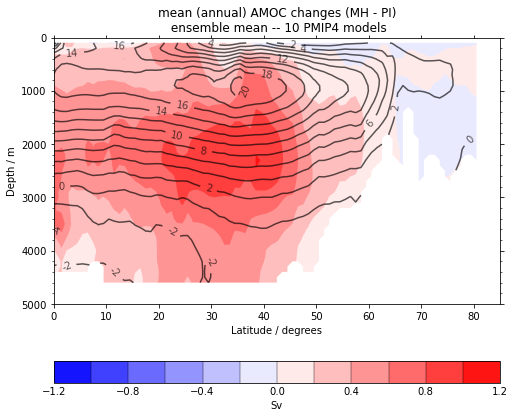

In [85]:
# plotting
fig=plt.figure(figsize=(8,7))
ax=fig.add_subplot(111)

qplt.contourf(mh_pi_indiv_diff_ave_1 , np.arange(-1.2,1.4,0.2), cmap='bwr')
figure=qplt.contour(pi_pmip4_amoc_model_ave_1, np.arange(-6,32,2), colors='k',alpha=0.65,linestyles='solid') 

ax.clabel(figure, inline=1, fontsize=10, fmt='%1.0f')

ax.yaxis.set_minor_locator(MultipleLocator(200))
ax.yaxis.set_major_locator(MultipleLocator(1000))
#ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.tick_params(which='both', direction='out', top=True, right=True, labelsize=10.)

# cut the white space:
ax.set_ylim(5000,0) #only show 0-5000m, as 5000-6000m is blank
ax.set_xlim(0,85)   # 85-90N is blank
ax.set(title='mean (annual) AMOC changes (MH - PI)\n ensemble mean -- 10 PMIP4 models')